# Project 1
Hayden Reid hjr160230

In [1]:
# md5 Hashing and data import

In [2]:
import hashlib
import sqlite3
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
hashlib.md5("hjr160230".encode('utf-8')).hexdigest()

'eb2f1d0d5902b3f2083c688ca607ff71'

In [4]:
# after hashing my NetID, my dataset is the 'recid' datasest. 

In [5]:
con = sqlite3.connect('wooldridge2.db')

In [6]:
recid = pd.read_sql('SELECT * FROM recid;',con)
labels = pd.read_sql('SELECT * FROM recid_labels;',con)

## Data Context

In [7]:
labels

,index,variable name,type,format,variable label
0,0,black,byte,%9.0g,=1 if black
1,1,alcohol,byte,%9.0g,=1 if alcohol problems
2,2,drugs,byte,%9.0g,=1 if drug history
3,3,super,byte,%9.0g,=1 if release supervised
4,4,married,byte,%9.0g,=1 if married when incarc.
5,5,felon,byte,%9.0g,=1 if felony sentence
6,6,workprg,byte,%9.0g,=1 if in N.C. pris. work prg.
7,7,property,byte,%9.0g,=1 if property crime
8,8,person,byte,%9.0g,=1 if crime against person
9,9,priors,byte,%9.0g,# prior convictions


The dataset name, recid, comes from the word recidivism, which is the tendency of a convicted crimial to reoffend, or commit another crime after their sentence has been served. The dataset is captured from a North Carolina prison, and is primarily concerned with determining how long after an inmate is released that they commit another crime. The variable used to determine this is 'durat', the duration (in months) after release that the inmate committed another crime. The dataset includes a number of variables, including categorical variables for whether the crimial is black ('black'), their abuse of drugs ('drugs') or alcohol ('alcohol'), if they participated in a work program while in prison ('workprg'), if the criminal was married ('married'), if their original sentence was a felony ('felon'), a crime against a person ('person'), or a crime against property ('property'). Additional variables such as the criminals age in months ('age'), time served ('tserved'), rules violated in prison ('rules'), are continous in nature. 
One important note to make is that not all criminals in the dataset wound up being recidivists, and their durat variable has been given a value between 70 and 81 months (considered to be "right censored"), in which time they were no longer followed for reoffense. 

## Exploratory Analysis

In [8]:
recid.mean()

index       722.000000
black         0.485121
alcohol       0.209689
drugs         0.241522
super         0.694118
married       0.255363
felon         0.314187
workprg       0.465052
property      0.254671
person        0.053287
priors        1.431834
educ          9.702422
rules         1.185467
age         345.435986
tserved      19.182007
follow       74.885813
durat        55.372318
dtype: float64

In [9]:
min(recid['age'])/12, max(recid['age'])/12, (recid['age']).mean()/12

(16.5, 77.75, 28.786332179930795)

Given the averages of each variable, we can see that 48% of the criminals in the dataset are black, 20% have a history
of alcohol abuse, and 24% have a history of drug abuse. The criminals also average 1.43 prior convictions. The average
education in the dataset is 9.7 years, meaning on average the criminals did not complete high school. Additionally, the average age of the group is 28 years old, with a minimum age of 16.5 years and a maximum age of 77.75.

First we can split the data into the censored 'durat' values and the uncensored values to determine any major prelimiary 
differences. This can be done by comparing the 'follow' variable to the 'durat' varaible, and if they are equal the criminal
was followed for the maximum time without committing another crime, and thus belongs to the censored group. 

In [10]:
censored = recid[recid['durat'] == recid['follow']]
uncensored = recid[recid['durat'] != recid['follow']]

In [11]:
len(uncensored)/len(recid)

0.38200692041522494

Of the 1445 criminals in the dataset, 38% of them were convicted again after their release. 

In [12]:
uncensored.mean() - censored.mean()

index       -3.925165
black        0.123744
alcohol      0.047641
drugs        0.043032
super       -0.023900
married     -0.073170
felon        0.004599
workprg      0.018443
property     0.056932
person      -0.004147
priors       0.740557
educ        -0.098897
rules        0.711226
age        -24.587725
tserved      6.732089
follow       0.123211
durat      -50.958311
dtype: float64

By differencing the mean values between the two groups, we can see any significant differences in their values. On average, the uncensored group has 12% more black criminals, a higher drug and alcohol abuse, more participation
in the work program, an average of .74 more prior convictions, an average of .71 more rules broken while incarcerated,
and a longer time served. 

To see if these variables have any meaningful statistical relationships, we can look at a correlation plot between them. 

In [13]:
corr = recid.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,index,black,alcohol,drugs,super,married,felon,workprg,property,person,priors,educ,rules,age,tserved,follow,durat
index,1,0.0079,-0.04,0.021,0.016,-0.037,0.011,-0.022,0.011,-0.022,-0.013,0.022,0.013,-0.03,0.021,0.016,-0.019
black,0.0079,1,-0.12,-0.16,0.043,-0.041,0.089,0.033,0.068,0.078,-0.012,0.11,0.024,-0.056,0.086,0.0024,-0.11
alcohol,-0.04,-0.12,1,-0.0087,-0.0086,0.1,-0.17,-0.075,-0.15,-0.024,0.16,-0.057,-0.088,0.22,-0.11,-0.19,-0.081
drugs,0.021,-0.16,-0.0087,1,-0.078,-0.041,-0.051,-0.014,-0.066,0.024,0.061,-0.085,0.043,0.062,-0.011,0.077,-0.04
super,0.016,0.043,-0.0086,-0.078,1,0.086,0.2,0.15,0.13,0.1,-0.11,0.035,-0.097,-0.043,0.1,-0.05,0.024
married,-0.037,-0.041,0.1,-0.041,0.086,1,0.0036,0.16,-0.036,0.038,0.03,-0.068,-0.087,0.24,-0.023,-0.038,0.09
felon,0.011,0.089,-0.17,-0.051,0.2,0.0036,1,0.22,0.7,0.31,0.033,0.039,0.23,-0.019,0.49,0.0021,-0.015
workprg,-0.022,0.033,-0.075,-0.014,0.15,0.16,0.22,1,0.15,0.094,0.11,0.0057,0.017,0.13,0.21,0.068,-0.0023
property,0.011,0.068,-0.15,-0.066,0.13,-0.036,0.7,0.15,1,-0.14,0.059,0.057,0.24,-0.075,0.36,0.049,-0.077
person,-0.022,0.078,-0.024,0.024,0.1,0.038,0.31,0.094,-0.14,1,0.016,-0.12,0.033,0.12,0.26,-0.054,0.0053


Using our initial correlation table, we can see high correlation between a few of the variables, namely property and felon.
this can likely be explained by the fact that many property related crimes are felonies, and therefore they capture
similar data. Additonally, the time served and felon variables are relatively highly correlated, and this may be because
felonies typically result in a longer time served than midemeanors. 

In [15]:
# for a more concise correlation table, I chose to eliminate the 'property' and 'person' variables for now.

df = recid[['black','alcohol','drugs','super','married','felon','workprg','priors','educ','rules','age','tserved','follow','durat']]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,black,alcohol,drugs,super,married,felon,workprg,priors,educ,rules,age,tserved,follow,durat
black,1,-0.12,-0.16,0.043,-0.041,0.089,0.033,-0.012,0.11,0.024,-0.056,0.086,0.0024,-0.11
alcohol,-0.12,1,-0.0087,-0.0086,0.1,-0.17,-0.075,0.16,-0.057,-0.088,0.22,-0.11,-0.19,-0.081
drugs,-0.16,-0.0087,1,-0.078,-0.041,-0.051,-0.014,0.061,-0.085,0.043,0.062,-0.011,0.077,-0.04
super,0.043,-0.0086,-0.078,1,0.086,0.2,0.15,-0.11,0.035,-0.097,-0.043,0.1,-0.05,0.024
married,-0.041,0.1,-0.041,0.086,1,0.0036,0.16,0.03,-0.068,-0.087,0.24,-0.023,-0.038,0.09
felon,0.089,-0.17,-0.051,0.2,0.0036,1,0.22,0.033,0.039,0.23,-0.019,0.49,0.0021,-0.015
workprg,0.033,-0.075,-0.014,0.15,0.16,0.22,1,0.11,0.0057,0.017,0.13,0.21,0.068,-0.0023
priors,-0.012,0.16,0.061,-0.11,0.03,0.033,0.11,1,-0.18,0.054,0.42,0.17,-0.03,-0.14
educ,0.11,-0.057,-0.085,0.035,-0.068,0.039,0.0057,-0.18,1,0.0091,-0.27,-0.054,0.039,0.016
rules,0.024,-0.088,0.043,-0.097,-0.087,0.23,0.017,0.054,0.0091,1,-0.14,0.51,-0.019,-0.18


Of the variables observed for correlation, black, priors, rules and tserved have a relatively high negative correlation
with the durat variable. Suprisingly, we see a relatively small correlation with drug/alcohol abuse with durat. 
'super', the variable that captures whether or not the release of the criminal was supervised, also seems to have no
relationship with the durat variable. 

# Problem Definition

Now that the data has been explored, I will define some structure for the following analysis. It seems the most practical variable to focus on is the 'durat' variable, through which we can determine what other variables have a statistical relationship with it to explain what factors play a role in the length of time between release and another criminal offense. 
For the first part of the analysis, I will attempt to determine the best model that explains the durat variable. My initial hypothesis is that the race of the criminal, the number of rules broken while incarcerated and the number of prior convictions will play a major role in explaining the tendency to commit another crime after being released.
Following the explanatory analysis, I will try to create a predictive model to predict whether or not a criminal will be locked up again. To do this, I plan to convert the durat variable to be categorical, where 1 represents a recidivist, and 0 represents a criminal who reached the maximum time followed without another crime. 
Finally I will conclude with my insights and take aways from the process. 

# Explanatory Analysis

In [16]:
recid2 = recid.copy()

In [17]:
model1 = smf.ols(formula="durat ~ workprg + priors + tserved + felon + alcohol + drugs + black + married + educ + \
                age", data=recid2).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  durat   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     18.27
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           8.56e-32
Time:                        22:22:21   Log-Likelihood:                -6741.5
No. Observations:                1445   AIC:                         1.351e+04
Df Residuals:                    1434   BIC:                         1.356e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.0758      4.061     11.837      0.000      40.109      56.043
workprg        0.0856      1.441      0.059      0.953      -2.741       2.912
priors        -1.5435      0.270     -5.717      0.000      -2.073      -1.014
tserved       -0.2872      0.038     -7.501      0.000      -0.362      -0.212
felon          5.2077      1.719      3.029      0.002       1.835       8.581
alcohol       -8.2424      1.761     -4.681      0.000     -11.696      -4.789
drugs         -3.5239      1.617     -2.179      0.030      -6.696      -0.351
black         -6.3043      1.396     -4.515      0.000      -9.044      -3.565
married        3.1759      1.632      1.946      0.052      -0.025       6.377
educ           0.3086      0.292      1.056      0.291      -0.265       0.882
age            0.0439      0.007      6.635      0.000       0.031       0.057
==============================================================================
Omnibus:                      211.893   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.555
Skew:                          -0.689   Prob(JB):                     7.47e-34
Kurtosis:                       2.205   Cond. No.                     2.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The first model is simply a large portion of the variables in the data regressed on the 'durat' variable. This model gives us a basic understanding of the statistical relationships between the dependent and independent variables. Here we see drugs, alcohol, and black are all statistically significant, and all have a relatively large coefficient. Our R-squared value for this model is quite low, meaning the variance in the durat variable is relatively unexplained by model 1. Next, I plan to change the model slightly to only include the significant variables, then evaluate the assumptions of linear regression: errors are normally distributed with mean 0 and equal variance. I am assuming that the observations are independent, given that they each correspond to a single inmate and not inmates over time. 

In [18]:
model2 = smf.ols(formula="durat ~ priors + tserved + felon + alcohol + drugs + black + married + age", \
                 data=recid2).fit(cov_type='HC3')
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  durat   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     20.92
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           3.09e-30
Time:                        22:22:22   Log-Likelihood:                -6742.1
No. Observations:                1445   AIC:                         1.350e+04
Df Residuals:                    1436   BIC:                         1.355e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.5694      2.408     21.416      0.000      46.850      56.289
priors        -1.5617      0.346     -4.508      0.000      -2.241      -0.883
tserved       -0.2895      0.050     -5.769      0.000      -0.388      -0.191
felon          5.3255      1.758      3.030      0.002       1.881       8.771
alcohol       -8.2178      1.840     -4.467      0.000     -11.824      -4.612
drugs         -3.6145      1.648     -2.193      0.028      -6.844      -0.385
black         -6.1722      1.404     -4.396      0.000      -8.924      -3.420
married        3.1636      1.531      2.066      0.039       0.162       6.165
age            0.0426      0.007      6.396      0.000       0.030       0.056
==============================================================================
Omnibus:                      217.417   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.050
Skew:                          -0.688   Prob(JB):                     5.83e-34
Kurtosis:                       2.194   Cond. No.                     1.35e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

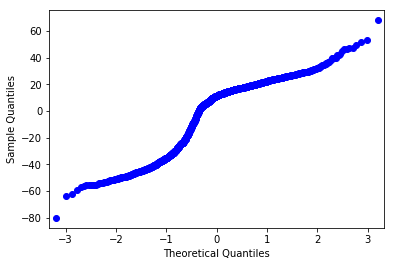

In [19]:
resid = model2.resid
fig = sm.qqplot(resid)

Using a qq plot, we can diagnose the assumption that our error term is normally distributed. In this case, I would say that it is not normally distributed. 

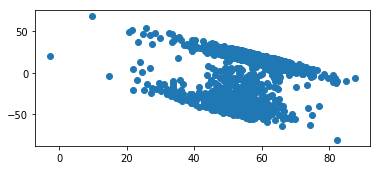

In [20]:
y_hat = model2.fittedvalues.copy()
y = recid2['durat'].values.copy()
resid = y - y_hat
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_hat, resid)

In [21]:
resid.mean()

-5.21523616295614e-14

To check the assumption that the errors are of mean 0 and equal variance, we can use a residual plot. Here we see another assumption violation, that error does not have an equal variance, but it does have a mean of 0. 

Considering the violations on OLS assumptions, I will try to fit similar models using only the unsensored data, that is criminals who committed another crime in the time that they were followed. 

In [22]:
model3 = smf.ols(formula="durat ~ workprg + priors + tserved + felon + alcohol + drugs + black + married + educ + \
                age", data=uncensored).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  durat   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.513
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           0.000165
Time:                        22:22:27   Log-Likelihood:                -2362.7
No. Observations:                 552   AIC:                             4747.
Df Residuals:                     541   BIC:                             4795.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.3796      4.761      5.541      0.000      17.028      35.731
workprg        2.0865      1.615      1.292      0.197      -1.087       5.260
priors        -0.6151      0.274     -2.244      0.025      -1.154      -0.077
tserved       -0.1507      0.038     -3.983      0.000      -0.225      -0.076
felon          2.0010      2.015      0.993      0.321      -1.957       5.959
alcohol       -3.7479      1.895     -1.978      0.048      -7.470      -0.026
drugs         -0.8891      1.740     -0.511      0.610      -4.307       2.528
black          0.2156      1.605      0.134      0.893      -2.937       3.368
married        3.4309      1.928      1.780      0.076      -0.355       7.217
educ          -0.3798      0.369     -1.028      0.304      -1.106       0.346
age            0.0136      0.008      1.653      0.099      -0.003       0.030
==============================================================================
Omnibus:                       59.280   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.982
Skew:                           0.913   Prob(JB):                     1.92e-17
Kurtosis:                       3.102   Cond. No.                     2.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Under the new model, we can see an insignificant relationship between the 'durat' variable and 'workprg', 'felon', 'drugs', 'black', and 'educ'. This justifies the possibility that the work program for inmates during their time in prison is statistically insignificant in increasing their time until committing another crime. Likewise, the abuse of drugs, felony charges, education status, and the criminal being black all had no statistical significance in increasing the time between release and committing another crime. 

Of the significant variables, 'alcohol' and 'married' have quite a significant effect on 'durat'. 
Coefficient interpretations:
If the criminal is married, there is an associated 3.4 month increase in the duration of time between release and committing another crime. 
If the criminal has a history of alcohol abuse, there is an associated 3.7 month decrease in the duration of time between release and committing another crime. 
For each prior conviction, there is an associated .62 month decrease in the duration of time between release and committing another crime. 

These interpretations are likely what one might expect, given that having a family (or in this case a spouse) might deter a criminal from committing another crime, as well as alcohol and priors being good indicators of another conviction sooner than a criminal with no priors or alcohol abuse. 

In [23]:
model4 = smf.ols(formula="durat ~ priors + tserved + alcohol + married + age", data=uncensored).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  durat   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     6.180
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.39e-05
Time:                        22:22:28   Log-Likelihood:                -2364.9
No. Observations:                 552   AIC:                             4742.
Df Residuals:                     546   BIC:                             4768.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.5345      2.605      8.650      0.000      17.417      27.652
priors        -0.6128      0.271     -2.260      0.024      -1.146      -0.080
tserved       -0.1166      0.031     -3.789      0.000      -0.177      -0.056
alcohol       -4.2373      1.842     -2.300      0.022      -7.856      -0.619
married        3.8304      1.915      2.001      0.046       0.069       7.591
age            0.0165      0.008      2.040      0.042       0.001       0.032
==============================================================================
Omnibus:                       59.117   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.781
Skew:                           0.913   Prob(JB):                     2.12e-17
Kurtosis:                       3.087   Cond. No.                     1.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

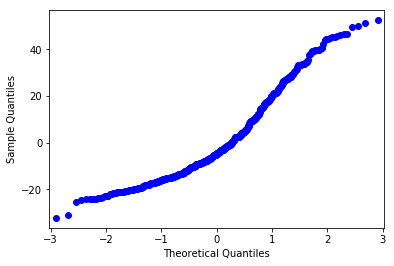

In [24]:
resid = model4.resid
fig = sm.qqplot(resid)

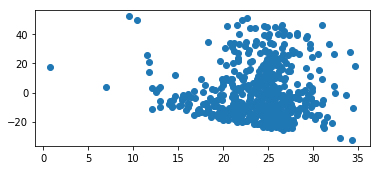

In [25]:
y_hat = model4.fittedvalues.copy()
y = uncensored['durat'].values.copy()
resid = y - y_hat
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_hat, resid)

In [26]:
resid.mean()

7.343562151288717e-14

Using the uncensored data models, we can check for any change in the assumptions on OLS. The normality of the error term still seems to be violated, but one might make an argument for the equal varaiance assumption being validated due to the apparent randomness and mean 0 of the error terms. 

Given the assumption violations seen in models 2 and 4, I can determine linear regression may not be the best explanatory model for this data. Next I will try and determine if there is multicollinearity (using VIF) in the data as I prepare to use logistic regression on the data. 

In [27]:
features = recid2[['black','alcohol','drugs','super','married','felon','workprg','priors','educ','rules','age','tserved']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif.round(1)

,VIF Factor,features
0,2.0,black
1,1.4,alcohol
2,1.3,drugs
3,3.4,super
4,1.5,married
5,2.1,felon
6,2.1,workprg
7,1.6,priors
8,7.4,educ
9,1.8,rules


Typically we use a threshold of 10 to consider there to be multicollinearity in a model, so among these variables we do not find there to be any problematic multicollinearity. 

Now that we have determined the absence of multicollinearity, I will convert the durat variable to a categorical variable for whether the criminal is a "recidivist" or not, that is, if they were convicted of another crime in the time they were observed or not. 

In [28]:
# creating a new categorical variable for recidivism. 

recid2['recidivist'] = 0
for i in range(len(recid2)):
    if recid2['follow'][i] == recid2['durat'][i]:
        recid2['recidivist'][i] = 0
    else:
        recid2['recidivist'][i] = 1

In [29]:
model3 = smf.logit(formula="recidivist ~ workprg + priors + property + person + tserved + felon + alcohol + drugs + black + married + educ + \
                age + educ", data=recid2).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.612803
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             recidivist   No. Observations:                 1445
Model:                          Logit   Df Residuals:                     1432
Method:                           MLE   Df Model:                           12
Date:                Sun, 07 Jul 2019   Pseudo R-squ.:                 0.07854
Time:                        22:22:45   Log-Likelihood:                -885.50
converged:                       True   LL-Null:                       -960.98
                                        LLR p-value:                 3.623e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2861      0.358      0.799      0.424      -0.415       0.988
workprg        0.1175      0.122      0.961      0.336      -0.122       0.357
priors         0.1252      0.025      5.016      0.000       0.076       0.174
property       0.5426      0.227      2.394      0.017       0.098       0.987
person         0.1757      0.339      0.518      0.605      -0.489       0.841
tserved        0.0184      0.004      5.189      0.000       0.011       0.025
felon         -0.8110      0.233     -3.482      0.000      -1.267      -0.355
alcohol        0.5667      0.149      3.815      0.000       0.276       0.858
drugs          0.3563      0.135      2.632      0.008       0.091       0.622
black          0.5825      0.119      4.914      0.000       0.350       0.815
married       -0.2148      0.141     -1.524      0.128      -0.491       0.061
educ          -0.0368      0.026     -1.426      0.154      -0.087       0.014
age           -0.0040      0.001     -6.015      0.000      -0.005      -0.003
==============================================================================
"""

In [30]:
model4 = smf.logit(formula="recidivist ~ priors + tserved + property + felon + alcohol + drugs + black + age", data=recid2).fit()
model4.summary()

Optimization terminated successfully.
         Current function value: 0.614629
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             recidivist   No. Observations:                 1445
Model:                          Logit   Df Residuals:                     1436
Method:                           MLE   Df Model:                            8
Date:                Sun, 07 Jul 2019   Pseudo R-squ.:                 0.07580
Time:                        22:22:47   Log-Likelihood:                -888.14
converged:                       True   LL-Null:                       -960.98
                                        LLR p-value:                 1.558e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1013      0.217     -0.466      0.641      -0.528       0.325
priors         0.1294      0.025      5.238      0.000       0.081       0.178
tserved        0.0193      0.003      5.547      0.000       0.012       0.026
property       0.4796      0.192      2.493      0.013       0.102       0.857
felon         -0.7449      0.199     -3.744      0.000      -1.135      -0.355
alcohol        0.5380      0.147      3.656      0.000       0.250       0.826
drugs          0.3760      0.135      2.788      0.005       0.112       0.640
black          0.5755      0.117      4.902      0.000       0.345       0.806
age           -0.0039      0.001     -6.263      0.000      -0.005      -0.003
==============================================================================
"""

Taking out the insignificant variables from the model, model 4 denotes a model in which all variables are statistically significant. 

In model 4, I am using a logit model rather than an ols model to better describe the situation. The recidivist variable is binary, and logit models better explain binary variables, so specifying this in the model will help capture the relationship better than ols. 
In this model, there are much stronger coefficient values for many of the variables, as well as some interesting interpretations on the significance of the variables. 
The 'workprg' variable denotes whether or not the criminals participated in the prison's work program while they were incarcerated. In model 2, we do not only see a statistically significant relationship between participation in the work program and recidivism. If the work program was designed to help prevent recidivism, this model might label the program as ineffective. 
Other statistically insignificant variables include the criminals marital status and thier education level. 

All other variables captured in this model are statistically significant at the 1% level (only 'property' at a slightly higher level of 1.3%). 
Some variable interpretations:
Every prior conviction increase of 1 is associated with a log-odds increase of .13 in recidivism.
A history of alcohol/drug abuse is associated with a log-odds increase of .53/.37 in recidivism, respectively. 
A criminal being black is associated with a log-odds increase in tendency of a convicted crimial to reoffend by .58. 

Interestingly, a criminal being considered a felon has an associated .74 log-odds decrease in recidivism. 

# Predictive Analysis

In [31]:
train, test = train_test_split(recid2, test_size=0.25)
X_test = test.drop(columns = ['recidivist','follow','durat'])
Y_test = test['recidivist']
X_train = train.drop(columns = ['recidivist','follow','durat'])
Y_train = train['recidivist']

In [32]:
model5 = LogisticRegression().fit(X_train, Y_train)
y_pred = model5.predict(X_test)
score = model5.score(X_test, Y_test)
score

C:\Users\Hayde\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6795580110497238

In [33]:
confusion = pd.crosstab(Y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
confusion

Predicted,0,1,All
Actual,,,
0,198,24,222
1,92,48,140
All,290,72,362


Using logistic regression to predict the recidivist variable, we get anywhere between 60 and 70% accuracy from the model. While we wouldn't want the model to be 100% accurate for fear of overfitting, 60% still seems on the low end. From our confusion matrix, we tend to classify more recidivists in the data than there really are. Similarly, though not as often, we classify recidivists as not, which in a practical sense would be more dangerous. 

# Conclusions

The biggest issue I found with this data was that the 'durat' variable was righ-censored, and that regression would capture the idea that all criminals in the data committed crimes again, when in reality they just reached the maximum time that they were to be followed and did not commit a crime. This skews the data, and creates a need for the splitting of the data between censored and uncensored to get a better idea of the relationships in the two. Perhaps given a larger sample size and more variables (such as further differentiation between race, number of kids, time in solitary confinement, etc.), we could better understand the actions of recidivists and their likelihood to committ more crimes. 

Of the analysis I was able to perform, I would conclude that the work program is ineffective in influencing the tendency of criminals to committ another crime. This of course could mean that the only incentive for being a part of the program was to increase standing and "good behavior" among the decision makers to lessen the sentence, or just a way to pass the time while inside. If the program was randomly assigned to inmates and was involuntary, then there could have been some sample selection bias that swayed the results of our analysis further. 

As for the models, I would say the most effective were the logistic regression models. Due to the nature of the data capturing process for the durat variable and its ambiguity, classifying the criminals in either of the two categories (recidivist or not) made the most sense to me. This way we could look at the whole dataset rather than a subset and draw conclusions based on more observations. I would say the explanatory models captured some meaningful relationships and interpretations, but the prediction model was not as effective as I might have hoped. 